Check accuracy of isostable elimination

# CGL 1

In [26]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
#import cgl_thalamic as ct
import cgl1 as c1
from cgl_thalamic import rhs_cgl

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

from sympy.utilities.lambdify import lambdify, implemented_function
imp_fn = implemented_function

In [27]:
reload(c1);reload(nm);reload(rp)
nmc = nm.nmCoupling;rsp = rp.Response

## Forcing function

In [28]:
pd2 = {'om':1,'amp':1,'om_fix':1,'esyn':0,'c':1}
def ff(x,a,om):
    return a*np.cos(om*x) + .1

In [29]:
# default period must be 2*np.pi
system2 = rsp(var_names=[],
              pardict=pd2,rhs=None,init=None,
              coupling=None,
              model_name='cgl_force1',
              forcing_fn=ff,
              idx=1,
              TN=0)

In [30]:
pd1 = {'q':1,'d':.9,'sig':.1,'rho':.15,'mu':.15,
       'om':1,'om_fix':1,'alc':3,'bec':2,'esyn':0}

system1 = rsp(var_names=['x','y','w'],
              pardict=pd1,rhs=rhs_cgl,
              init=np.array([.333,0,0,2*np.pi]),
              TN=2000,
              idx=0,
              model_name='cglf0',
              
              recompute_list=[],
              z_forward=False,
              i_forward=False,
              i_bad_dx=False,
              coupling=c1.coupling_cgl)

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.02999999999993149
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [31]:
a = nmc(system1,system2,
       recompute_list=['p_cglf0','h_cglf0','p_data_cglf0','h_data_cglf0'],
       _n=('om0',1),_m=('om1',2),
       NP=100,NH=100)

In [32]:
rule = {**system1.rule_p,**system2.rule_p,
        **system1.rule_par,**system2.rule_par,
        **system1.rule_lc,**system2.rule_lc,
        **system1.rule_i,**system2.rule_i,
        **system1.rule_g,**system2.rule_g}

## Lambdified forcing functions

In [33]:
imp0 = imp_fn('forcing',system2)
lam0 = lambdify(a.ths[1],imp0(a.ths[1]))
rule.update({system2.syms[0]:imp0(a.ths[1])})

In [34]:
print(system1.p['sym'][1].subs(rule))

-forcing(th1)*ix0_0(th0)


In [35]:
# collect forcing function for each order
p_het_lam = []
for i in range(system1.miter):
    p_het_lam.append(sym.lambdify(a.ths,system1.p['sym'][i].subs(rule)))
    print(system1.p['sym'][i].subs(rule))

0
-forcing(th1)*ix0_0(th0)
-forcing(th1)*ix0_1(th0)*p_cglf0_1(th0, th1)


In [36]:
# check forcing function works
p_het_lam[2](1,1)

-0.06871779452579957

In [37]:
om = a._n[1]/a._m[1]

In [38]:
from lib.fast_interp import interp2d # remove endpoint when working with fast_interp
from sympy.utilities.lambdify import lambdify, implemented_function
imp_fn = implemented_function

# Calculate

## p brute

In [39]:
NA = 50;NB = 51

x1,dx1 = np.linspace(0,2*np.pi,NA,retstep=True,endpoint=False)
x2,dx2 = np.linspace(0,2*np.pi*a._m[1],NB,retstep=True,endpoint=False)

het0 = np.zeros((NA,NB))
s = np.arange(0,a.T*a.pfactor*a._m[1],dx1)
exponential = np.exp(om*s*system1.kappa_val)

for i in range(NA):
    for j in range(NB):
        f1 = p_het_lam[1](x1[i]+om*(x2[j]-s),x2[j]-s)
        #f1 = np.cos(x1[i]+om*(x2[j]-s))*np.cos(x2[j]-s)
        het0[i,j] = np.sum(f1*exponential)
    #print(het0[i,:])
        
het0 *= om*dx1

In [40]:
# in slow theta, fast s
p_int0b = interp2d([0,0],[x1[-1],x2[-1]],[dx1,dx2],het0,k=3,p=[True,True])
#p_imp1b = imp_fn('px_test1b',a.fast_interp_lam(p_int0b))
#p_lam1b = lambdify(a.ths,p_imp1b(a.ths[0],a.ths[1]))

# this is now in fast theta, fast s.
X,Y = np.meshgrid(x1,x2,indexing='ij')
#het1 = p_int0b(X+Y*om,Y)
het1 = p_int0b(X,Y)

p_int1b = interp2d([0,0],[x1[-1],x2[-1]],[dx1,dx2],het1,k=3,p=[True,True])
p_imp1b = imp_fn('px_test1b',a.fast_interp_lam(p_int1b))
p_lam1b = lambdify(a.ths,p_imp1b(a.ths[0],a.ths[1]))

## p conv

In [41]:
NP = 150
p_data0 = np.zeros((NP,int(a._m[1]*NP)))
r,dr = np.linspace(0,2*np.pi,NP,retstep=True,endpoint=False)
s1 = np.arange(0,a.T*a.pfactor*a._m[1],dr)

exponential = np.exp(om*s1*system1.kappa_val)
g_in = np.fft.fft(exponential)

for ll in range(len(r)):
    f_in = np.fft.fft(p_het_lam[1](r[ll]+om*s1,+s1))
    #f_in = np.fft.fft(np.cos(r[ll]-om*s1)*np.cos(-s1))
    conv = np.fft.ifft(f_in*g_in)
    p_data0[ll,:] = conv[-2*NP:].real
    
    #print(conv[-NP:].real)
    
p_data0 *= om*dr

In [42]:
# in slow theta, fast s
p_int0c = interp2d([0,0],[2*np.pi,2*np.pi*a._m[1]],[dr,dr],p_data0,k=3,p=[True,True])
#p_imp1c = imp_fn('px_test1c',a.fast_interp_lam(p_int0c))
#p_lam1c = lambdify(a.ths,p_imp1c(a.ths[0],a.ths[1]))

X,Y = np.meshgrid(a.an,a.an*a._m[1],indexing='ij')
# this is now in fast theta, fast s.
#p_data1 = p_int0c(X+om*Y,Y) 
p_data1 = p_int0c(X,Y)

p_int1c = interp2d([0,0],[2*np.pi,2*np.pi*a._m[1]],[a.dan,a.dan*a._m[1]],p_data1,k=3,p=[True,True])
p_imp1c = imp_fn('px_test1c',a.fast_interp_lam(p_int1c))
p_lam1c = lambdify(a.ths,p_imp1c(a.ths[0],a.ths[1]))

### plot conv vs brute *given* theta_X

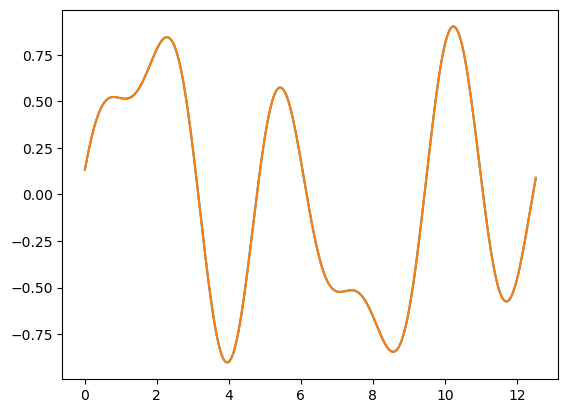

In [43]:
thx = 1
thys = np.arange(0,2*np.pi*a._m[1],dr)
st = np.arange(0,a.T*a.pfactor*a._m[1],dr)
exponential = np.exp(om*st*system1.kappa_val)

# conv
g_in = np.fft.fft(exponential)
f_in = np.fft.fft(p_het_lam[1](thx+om*st,+st)) #???????????????????????????????????????????????
conv2 = np.fft.ifft(f_in*g_in).real*dr

# brute
brute2 = np.zeros(len(thys))
for i in range(len(thys)):
    f1 = p_het_lam[1](thx+om*(thys[i]-st),thys[i]-st)
    brute2[i] = np.sum(f1*exponential)*dr
    
fig,axs = plt.subplots()

axs.plot(thys,conv2[-len(thys):])
axs.plot(thys,brute2)

## Notes on functions vs indices

Now that we have calculated the values above for *slow* $\hat\theta_X$ and *fast* $s$ above (as opposed to *fast* $\theta_X$ and *fast* $s$ as in the coupling case), we need to make sure that the corresponding data matrix is correct, and modify the $\mathcal{H}$ function calculations appropriately. In particular, what we have done is calculated the data matrix from the function $g(\hat\theta_X,s) = p_X^{(1)}(\hat\theta_X + \omega s, s)$, where $\hat\theta_X$ corresponds to the $i$ (row) index of the data matrix and $s$ to the $j$ (column) index. So to get $p_X^{(1)}(\hat\theta_X, s)$, we would use the transformation

$$g(\hat\theta_X- \omega s,s) = p_X^{(1)}(\hat\theta_X, s).$$

While we use $p_X^{(1)}(\hat\theta_X + \omega s, s)$ in the $\mathcal{H}$ function calculations, the other functions depend on $\hat\theta_X$ directly and thus we should transform the lambdified function appropriately. This can be done by:

```
p_int1c0 = interp2d([0,0],[2*np.pi,2*np.pi],[dr,dr],p_data1,k=3,p=[True,True])
X,Y = np.meshgrid(a.an,a.an,indexing='ij')
p_data1 = p_int1c0(X-Y*om,Y)
```

If we assume `p_lam` is the lambdified function of the `NP` by `NP` data matrix, then

```
h_lam = lambdify(self.ths,system1.h['sym'][k].subs(rule))
for j in range(self.NH):
    h[j] = np.sum(h_lam(bn[j] + om*bn,bn))
```

where `NH` is the number of gridpoints in the $\mathcal{H}$ calculation, `self.ths` is a list of sympy variables for $\theta_X$ and $\theta_Y$, `system1.h['sym'][k].subs(rule)` is the $\mathcal{H}$ function for order $k$ after substitution with lambdified/implemented functions (just a technicality -- this is just \mathcal{H} of order $k$), `bn` is a linspace for $[0,2\pi)$ with `NH` gridpoints, and `om=n/m`.

# Plots

## Plot slice

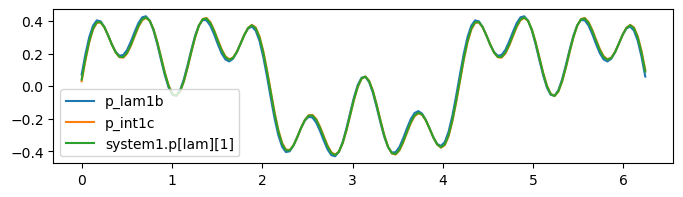

In [44]:
# convolve jupyter vs brute jupyter vs brute nmcoupling

# ll = 0;f1 = lam1(r[ll]+om2*s1,s1)
# fa = np.fft.fft(f1)d
# conv = np.fft.ifft(fa*fb)*om*dr

thatY = 0
fac = 3

ll = 0

fig,axs = plt.subplots(figsize=(8,2))
axs.plot(r,p_lam1b(r[ll]+fac*r,fac*r+thatY),label='p_lam1b')
#axs.plot(r,p_intb(r[ll]+fac*r,fac*r+thatY),label='p_int1b')
#axs.plot(p_data1[(a_i+ll)%NP,a_i],label='p_data1[(a_i+ll)%NP,a_i]')
axs.plot(r,p_int1c(fac*r+r[ll],fac*r+thatY),label='p_int1c')
axs.plot(r,system1.p['lam'][1](fac*r+r[ll],fac*r+thatY),label='system1.p[lam][1]')
#axs.set_xlim(len(s1)-NP,len(s1))
axs.legend()

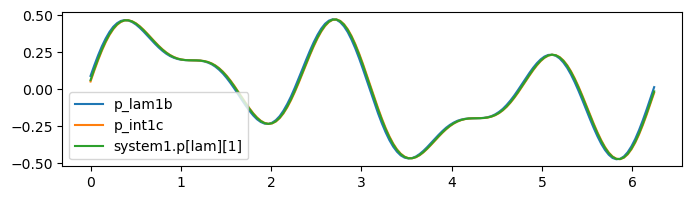

In [45]:
thatY = 0
fac = 2
ll = 10

xin = np.zeros(len(r)) + r[ll]
yin = fac*r+thatY

fig,axs = plt.subplots(figsize=(8,2))
axs.plot(r,p_lam1b(xin,yin),label='p_lam1b')
axs.plot(r,p_int1c(xin,yin),label='p_int1c')
axs.plot(r,system1.p['lam'][1](xin,yin),label='system1.p[lam][1]')
axs.legend()

## Plot surface

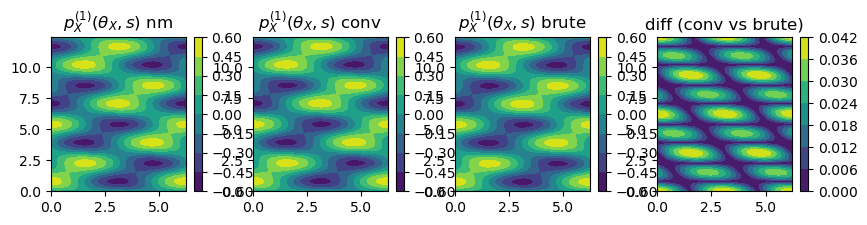

In [46]:
fig,axs = plt.subplots(1,4,figsize=(10,2))
lamout_conv = p_int1c(X,Y)
lamout_brut = p_lam1b(X,Y)
#lamout_brut = system1.p['dat'][1]
lamout_nmco = system1.p['lam'][1](X,Y)
im0 = axs[0].contourf(X,Y,lamout_nmco)
im1 = axs[1].contourf(X,Y,lamout_conv)
im2 = axs[2].contourf(X,Y,lamout_brut)
im3 = axs[3].contourf(X,Y,np.abs(lamout_conv - lamout_brut))

axs[0].set_title(r'$p_X^{(1)}(\theta_X,s)$ nm')
axs[1].set_title(r'$p_X^{(1)}(\theta_X,s)$ conv')
axs[2].set_title(r'$p_X^{(1)}(\theta_X,s)$ brute')
axs[3].set_title(r'diff (conv vs brute)')

plt.colorbar(im0,ax=axs[0])
plt.colorbar(im1,ax=axs[1])
plt.colorbar(im2,ax=axs[2])
plt.colorbar(im3,ax=axs[3])

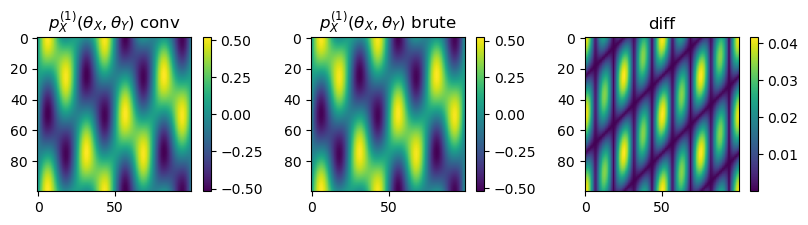

In [47]:
fig,axs = plt.subplots(1,3,figsize=(10,2))
im0 = axs[0].imshow(lamout_conv)
im1 = axs[1].imshow(lamout_brut)
im2 = axs[2].imshow(np.abs(lamout_conv - lamout_brut))

axs[0].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ conv')
axs[1].set_title(r'$p_X^{(1)}(\theta_X,\theta_Y)$ brute')
axs[2].set_title(r'diff')

plt.colorbar(im0,ax=axs[0])
plt.colorbar(im1,ax=axs[1])
plt.colorbar(im2,ax=axs[2])

In [23]:
(system1.K['sym']['x0'][0]).subs(rule)

-forcing(th1)

In [24]:
K_lam = sym.lambdify(a.ths,system1.K['sym']['x0'][0].subs(rule))
K_lam(1,2)*system1.i['lam_x0'][0](1)

-0.5316015148960698

In [25]:
# ### plot het. terms for p. direct vs precalculated.
# fig,axs = plt.subplots(figsize=(8,2))
# ttemp = np.linspace(0,4*np.pi,100)
# th0 = 1;th1 = 2
# axs.plot(system1.i['lam_x0'][0](th0+ttemp*om)*K_lam(th0+ttemp*om,th1+ttemp)) # directly calcualted het. term
# axs.plot(p_het_lam[1](th0+ttemp*om,th1+ttemp)) # pre-calculated symbolic het. term
# axs.set_title('plot het. terms for p. direct vs precalculated.')

# Integerate ODE and brute

In [31]:
def px1(t,p,thatX,thatY):
    dp = system1.kappa_val*p + p_het_lam[1](thatX+om*t,thatY+t)
    return dp*om

In [32]:
thatX = 1;thatY = 5

In [33]:
t = np.arange(0,100*2*np.pi,.01)
sol = solve_ivp(px1,[0,t[-1]],[4.4],args=(thatX,thatY),t_eval=t,method='LSODA',atol=1e-7,rtol=1e-7)

In [34]:
skipn = 100
sol_brute = np.zeros(len(t[::skipn]))

for i in range(len(t[::skipn])):
    s = np.arange(0,t[::skipn][i],a.dan)
    f1 = p_het_lam[1](thatX+om*s,thatY+s)
    sol_brute[i] = om*np.sum(f1*np.exp(om*(t[::skipn][i]-s)*system1.kappa_val))*a.dan

### $p_X^{(1)}(\hat\theta_X+\omega s,\hat\theta_Y+s)$ versus $p_X^{(1)}(s)$

Compare brute integration, ODE integration, and convolution. All should be equivalent. All methods require integrating over long enough times, the convolution is the most efficient.

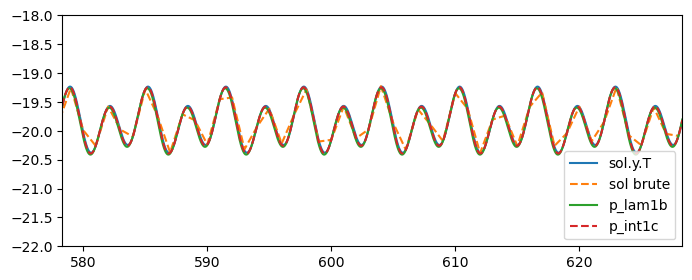

In [35]:
# plot solution
startn = 30000
fig,axs = plt.subplots(figsize=(8,3))
axs.plot(t,sol.y.T,label='sol.y.T')
axs.plot(t[::skipn],sol_brute,label='sol brute',ls='--')
axs.plot(t,p_lam1b(thatX+t,thatY+t),label='p_lam1b')
axs.plot(t,p_int1c(thatX+t,thatY+t),label='p_int1c',ls='--')
#axs.plot(t,system1.p['lam'][1](thatX+t,thatY+t),label='plam',alpha=.4)
axs.set_xlim(t[-1]-50,t[-1])
axs.set_ylim(-22,-18)
axs.legend()

In [36]:
sol.y.T[-1]

array([-19.82255036])

In [37]:
system1.p['lam'][1](np.array([thatX]),np.array([thatY]))

array([-19.80264754])

# Meshgrid conventions

I'm very confused by
1. defining matrix based on x,y vs ij coordinates.
2. going from 1d conv as defined above to theta_x, theta_y coordinates.